In [1]:
import numpy as np
import pandas as pd
import polars as pl
import os, gc, warnings
from glob import glob
from pathlib import Path
from typing import Any
from itertools import combinations, permutations
from tqdm import tqdm

warnings.filterwarnings("ignore")

ROOT = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR = ROOT / "parquet_files" / "train"
TEST_DIR = ROOT / "parquet_files" / "test"

# preprocessing

In [2]:
class Utility:
    @staticmethod
    def get_feat_defs(ending_with: str) -> None:
        """
        Retrieves feature definitions from a CSV file based on the specified ending.

        Args:
        - ending_with (str): Ending to filter feature definitions.

        Returns:
        - pl.DataFrame: Filtered feature definitions.
        """
        feat_defs: pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv")

        filtered_feats: pl.DataFrame = feat_defs.filter(
            pl.col("Variable").apply(lambda var: var.endswith(ending_with))
        )

        with pl.Config(fmt_str_lengths=200, tbl_rows=-1):
            print(filtered_feats)

        filtered_feats = None
        feat_defs = None

    @staticmethod
    def find_index(lst: list[Any], item: Any) -> int | None:
        """
        Finds the index of an item in a list.

        Args:
        - lst (list): List to search.
        - item (Any): Item to find in the list.

        Returns:
        - int | None: Index of the item if found, otherwise None.
        """
        try:
            return lst.index(item)
        except ValueError:
            return None

    @staticmethod
    def dtype_to_str(dtype: pl.DataType) -> str:
        """
        Converts Polars data type to string representation.

        Args:
        - dtype (pl.DataType): Polars data type.

        Returns:
        - str: String representation of the data type.
        """
        dtype_map = {
            pl.Decimal: "Decimal",
            pl.Float32: "Float32",
            pl.Float64: "Float64",
            pl.UInt8: "UInt8",
            pl.UInt16: "UInt16",
            pl.UInt32: "UInt32",
            pl.UInt64: "UInt64",
            pl.Int8: "Int8",
            pl.Int16: "Int16",
            pl.Int32: "Int32",
            pl.Int64: "Int64",
            pl.Date: "Date",
            pl.Datetime: "Datetime",
            pl.Duration: "Duration",
            pl.Time: "Time",
            pl.Array: "Array",
            pl.List: "List",
            pl.Struct: "Struct",
            pl.String: "String",
            pl.Categorical: "Categorical",
            pl.Enum: "Enum",
            pl.Utf8: "Utf8",
            pl.Binary: "Binary",
            pl.Boolean: "Boolean",
            pl.Null: "Null",
            pl.Object: "Object",
            pl.Unknown: "Unknown",
        }

        return dtype_map.get(dtype)

    @staticmethod
    def find_feat_occur(regex_path: str, ending_with: str) -> pl.DataFrame:
        """
        Finds occurrences of features ending with a specific string in Parquet files.

        Args:
        - regex_path (str): Regular expression to match Parquet file paths.
        - ending_with (str): Ending to filter feature names.

        Returns:
        - pl.DataFrame: DataFrame containing feature definitions, data types, and file locations.
        """
        feat_defs: pl.DataFrame = pl.read_csv(ROOT / "feature_definitions.csv").filter(
            pl.col("Variable").apply(lambda var: var.endswith(ending_with))
        )
        feat_defs.sort(by=["Variable"])

        feats: list[pl.String] = feat_defs["Variable"].to_list()
        feats.sort()

        occurrences: list[list] = [[set(), set()] for _ in range(feat_defs.height)]

        for path in glob(str(regex_path)):
            df_schema: dict = pl.read_parquet_schema(path)

            for feat, dtype in df_schema.items():
                index: int = Utility.find_index(feats, feat)
                if index != None:
                    occurrences[index][0].add(Utility.dtype_to_str(dtype))
                    occurrences[index][1].add(Path(path).stem)

        data_types: list[str] = [None] * feat_defs.height
        file_locs: list[str] = [None] * feat_defs.height

        for i, feat in enumerate(feats):
            data_types[i] = list(occurrences[i][0])
            file_locs[i] = list(occurrences[i][1])

        feat_defs = feat_defs.with_columns(pl.Series(data_types).alias("Data_Type(s)"))
        feat_defs = feat_defs.with_columns(pl.Series(file_locs).alias("File_Loc(s)"))

        return feat_defs

    def reduce_memory_usage(df: pl.DataFrame, name) -> pl.DataFrame:
        """
        Reduces memory usage of a DataFrame by converting column types.

        Args:
        - df (pl.DataFrame): DataFrame to optimize.
        - name (str): Name of the DataFrame.

        Returns:
        - pl.DataFrame: Optimized DataFrame.
        """
        print(
            f"Memory usage of dataframe \"{name}\" is {round(df.estimated_size('mb'), 4)} MB."
        )

        int_types = [
            pl.Int8,
            pl.Int16,
            pl.Int32,
            pl.Int64,
            pl.UInt8,
            pl.UInt16,
            pl.UInt32,
            pl.UInt64,
        ]
        float_types = [pl.Float32, pl.Float64]

        for col in df.columns:
            col_type = df[col].dtype
            if col_type in int_types + float_types:
                c_min = df[col].min()
                c_max = df[col].max()

                if c_min is not None and c_max is not None:
                    if col_type in int_types:
                        if c_min >= 0:
                            if (
                                c_min >= np.iinfo(np.uint8).min
                                and c_max <= np.iinfo(np.uint8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt8))
                            elif (
                                c_min >= np.iinfo(np.uint16).min
                                and c_max <= np.iinfo(np.uint16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt16))
                            elif (
                                c_min >= np.iinfo(np.uint32).min
                                and c_max <= np.iinfo(np.uint32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt32))
                            elif (
                                c_min >= np.iinfo(np.uint64).min
                                and c_max <= np.iinfo(np.uint64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.UInt64))
                        else:
                            if (
                                c_min >= np.iinfo(np.int8).min
                                and c_max <= np.iinfo(np.int8).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int8))
                            elif (
                                c_min >= np.iinfo(np.int16).min
                                and c_max <= np.iinfo(np.int16).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int16))
                            elif (
                                c_min >= np.iinfo(np.int32).min
                                and c_max <= np.iinfo(np.int32).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int32))
                            elif (
                                c_min >= np.iinfo(np.int64).min
                                and c_max <= np.iinfo(np.int64).max
                            ):
                                df = df.with_columns(df[col].cast(pl.Int64))
                    elif col_type in float_types:
                        if (
                            c_min > np.finfo(np.float32).min
                            and c_max < np.finfo(np.float32).max
                        ):
                            df = df.with_columns(df[col].cast(pl.Float32))

        print(
            f"Memory usage of dataframe \"{name}\" became {round(df.estimated_size('mb'), 4)} MB."
        )

        return df

    def to_pandas(df: pl.DataFrame, cat_cols: list[str] = None) -> (pd.DataFrame, list[str]):  # type: ignore
        """
        Converts a Polars DataFrame to a Pandas DataFrame.

        Args:
        - df (pl.DataFrame): Polars DataFrame to convert.
        - cat_cols (list[str]): List of categorical columns. Default is None.

        Returns:
        - (pd.DataFrame, list[str]): Tuple containing the converted Pandas DataFrame and categorical columns.
        """
        df: pd.DataFrame = df.to_pandas()

        if cat_cols is None:
            cat_cols = list(df.select_dtypes("object").columns)

        df[cat_cols] = df[cat_cols].astype("category")

        return df, cat_cols

In [3]:
class Aggregator:
    @staticmethod
    def max_expr(cols) -> list[pl.Series]:
        """
        Generates expressions for calculating maximum values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for maximum values.
        """
        cols: list[str] = [
            col
            for col in cols
            if (col[-1] in ("P", "M", "A", "D", "T", "L")) or ("num_group" in col)
        ]

        expr_max: list[pl.Series] = [
            pl.col(col).max().alias(f"{col}_MAX") for col in cols
        ]

        return expr_max

    @staticmethod
    def min_expr(cols) -> list[pl.Series]:
        """
        Generates expressions for calculating minimum values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for minimum values.
        """
        cols: list[str] = [
            col
            for col in cols
            if (col[-1] in ("P", "M", "A", "D", "T", "L")) or ("num_group" in col)
        ]

        expr_min: list[pl.Series] = [
            pl.col(col).min().alias(f"{col}_MIN") for col in cols
        ]

        return expr_min

    @staticmethod
    def mean_expr(cols) -> list[pl.Series]:
        """
        Generates expressions for calculating mean values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for mean values.
        """
        cols: list[str] = [col for col in cols if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).mean().alias(f"{col}_MEAN") for col in cols
        ]

        return expr_mean

    @staticmethod
    def var_expr(cols) -> list[pl.Series]:
        """
        Generates expressions for calculating variance for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for variance.
        """
        cols: list[str] = [col for col in cols if col.endswith(("P", "A", "D"))]

        expr_mean: list[pl.Series] = [
            pl.col(col).var().alias(f"{col}_VAR") for col in cols
        ]

        return expr_mean

    @staticmethod
    def mode_expr(cols) -> list[pl.Series]:
        """
        Generates expressions for calculating mode values for specific columns.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of expressions for mode values.
        """
        cols: list[str] = [col for col in cols if col.endswith("M")]

        expr_mode: list[pl.Series] = [
            pl.col(col).drop_nulls().mode().first().alias(f"{col}_MODE") for col in cols
        ]

        return expr_mode

    @staticmethod
    def get_exprs(df: pl.LazyFrame) -> list[pl.Series]:
        """
        Combines expressions for maximum, mean, and variance calculations.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - list[pl.Series]: List of combined expressions.
        """
        eligible_cols = [x for x in df.columns if 'education' not in x]
        exprs = (
            Aggregator.max_expr(df) + Aggregator.mean_expr(df) + Aggregator.var_expr(df)
        )

        return exprs

In [4]:
class SchemaGen:
    @staticmethod
    def change_dtypes(df: pl.LazyFrame) -> pl.LazyFrame:
        """
        Changes the data types of columns in the DataFrame.

        Args:
        - df (pl.LazyFrame): Input LazyFrame.

        Returns:
        - pl.LazyFrame: LazyFrame with modified data types.
        """
        for col in df.columns:
            if col == "case_id":
                df = df.with_columns(pl.col(col).cast(pl.UInt32).alias(col))
            elif col in ["WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.UInt16).alias(col))
            elif col == "date_decision" or col[-1] == "D":
                df = df.with_columns(pl.col(col).cast(pl.Date).alias(col))
            elif col[-1] in ["P", "A"]:
                df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
        return df

    @staticmethod
    def scan_files(glob_path: str, depth: int = None):
        chunks = []
        for path in glob(str(glob_path)):
            df = pl.read_parquet(path, low_memory=True, rechunk=True)
            df = df.pipe(SchemaGen.change_dtypes)
            if depth in [1, 2]:
                df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
            chunks.append(df)
        df = pl.concat(chunks, how="vertical_relaxed")
        del chunks
        gc.collect()

        df = df.unique(subset=["case_id"]) 
        
        return df

    @staticmethod
    def join_dataframes(df_base, depth_0, depth_1, depth_2):
        for i, df in enumerate(depth_0 + depth_1 + depth_2):
            df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        return df_base


In [5]:
def filter_cols(df: pl.DataFrame) -> pl.DataFrame:
    """
    Filters columns in the DataFrame based on null percentage and unique values for string columns.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with filtered columns.
    """
    for col in df.columns:
        if col not in ["case_id", "year", "month", "week_num", "target"]:
            null_pct = df[col].is_null().mean()

            if null_pct > 0.95:
                df = df.drop(col)

    for col in df.columns:
        if (col not in ["case_id", "year", "month", "week_num", "target"]) & (
            df[col].dtype == pl.String
        ):
            freq = df[col].n_unique()

            if (freq > 200) | (freq == 1):
                df = df.drop(col)

    return df


def transform_cols(df: pl.DataFrame) -> pl.DataFrame:
    """
    Transforms columns in the DataFrame according to predefined rules.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with transformed columns.
    """
    if "riskassesment_302T" in df.columns:
        if df["riskassesment_302T"].dtype == pl.Null:
            df = df.with_columns(
                [
                    pl.Series(
                        "riskassesment_302T_rng", df["riskassesment_302T"], pl.UInt8
                    ),
                    pl.Series(
                        "riskassesment_302T_mean", df["riskassesment_302T"], pl.UInt8
                    ),
                ]
            )
        else:
            pct_low: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[0].replace("%", ""))
                .cast(pl.UInt8)
            )
            pct_high: pl.Series = (
                df["riskassesment_302T"]
                .str.split(" - ")
                .apply(lambda x: x[1].replace("%", ""))
                .cast(pl.UInt8)
            )

            diff: pl.Series = pct_high - pct_low
            avg: pl.Series = ((pct_low + pct_high) / 2).cast(pl.Float32)

            del pct_high, pct_low
            gc.collect()

            df = df.with_columns(
                [
                    diff.alias("riskassesment_302T_rng"),
                    avg.alias("riskassesment_302T_mean"),
                ]
            )

        df.drop("riskassesment_302T")

    return df


def handle_dates(df: pl.DataFrame) -> pl.DataFrame:
    """
    Handles date columns in the DataFrame.

    Args:
    - df (pl.DataFrame): Input DataFrame.

    Returns:
    - pl.DataFrame: DataFrame with transformed date columns.
    """
    for col in df.columns:
        if (col[-1] == 'D') or ('D_' in col):
            df = df.with_columns(pl.col("date_decision") - pl.col(col) )
            df = df.with_columns(pl.col(col).dt.total_days().cast(pl.Int32))

    df = df.rename(
        {
            "MONTH": "month",
            "WEEK_NUM": "week_num"
        }
    )
            
    df = df.with_columns(
        [
            pl.col("date_decision").dt.year().alias("year").cast(pl.Int16),
            pl.col("date_decision").dt.day().alias("day").cast(pl.UInt8),
            pl.col("date_decision").dt.weekday().alias("weekday").cast(pl.UInt8),
        ]
    )

#     df = df.drop("date_decision")
    df = df.drop("month")
    return df

# Loading Data

In [6]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        SchemaGen.scan_files(TRAIN_DIR / "train_static_cb_0.parquet"),
        SchemaGen.scan_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        SchemaGen.scan_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_other_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_person_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_deposit_1.parquet", 1),
        SchemaGen.scan_files(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ],
}

df_train: pl.DataFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(filter_cols)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .pipe(Utility.reduce_memory_usage, "df_train")
)

del data_store
gc.collect()

print(f"Train data shape: {df_train.shape}")
display(df_train.head(10))

Memory usage of dataframe "df_train" is 4705.3958 MB.
Memory usage of dataframe "df_train" became 2665.6302 MB.
Train data shape: (1526659, 472)


case_id,date_decision,week_num,target,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtcount_4527229L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,responsedate_4917613D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,…,mainoccupationinc_384A_MEAN,amount_416A_MAX,num_group1_MAX_10,openingdate_313D_MAX,amount_416A_MEAN,openingdate_313D_MEAN,num_group1_MAX_11,openingdate_857D_MAX,openingdate_857D_MEAN,collater_typofvalofguarant_298M_MAX,collater_typofvalofguarant_407M_MAX,collater_valueofguarantee_1124L_MAX,collater_valueofguarantee_876L_MAX,collaterals_typeofguarante_359M_MAX,collaterals_typeofguarante_669M_MAX,num_group1_MAX_12,num_group2_MAX,pmts_dpd_1073P_MAX,pmts_dpd_303P_MAX,pmts_month_158T_MAX,pmts_month_706T_MAX,pmts_overdue_1140A_MAX,pmts_overdue_1152A_MAX,pmts_year_1139T_MAX,pmts_year_507T_MAX,subjectroles_name_541M_MAX,subjectroles_name_838M_MAX,pmts_dpd_1073P_MEAN,pmts_dpd_303P_MEAN,pmts_overdue_1140A_MEAN,pmts_overdue_1152A_MEAN,pmts_dpd_1073P_VAR,pmts_dpd_303P_VAR,pmts_overdue_1140A_VAR,pmts_overdue_1152A_VAR,year,day
u32,date,u8,u8,i16,u8,i16,f32,i32,f32,f32,f32,f32,f32,str,str,str,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,str,i8,u8,i8,f32,f32,f32,f32,f32,…,f32,f32,u8,i16,f32,i16,u8,i16,i16,str,str,f32,f32,str,str,u16,u8,f32,f32,f32,f32,f32,f32,f32,f32,str,str,f32,f32,f32,f32,f32,f32,f32,f32,u16,u8
30178,2019-09-12,36,0,null,null,null,null,-21165,3.0,4.0,1.0,9.0,2.0,"""a55475b1""","""a55475b1""","""a55475b1""",2.0,6.0,"""a55475b1""","""a55475b1""",9.0,null,null,null,6.0,6.0,12000.0,"""DEDUCTION_6""",14,14,null,4.0,2.0,null,null,3173.0,…,64000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,35,0.0,null,12.0,null,0.0,null,2020.0,null,"""a55475b1""","""ab3c25cf""",0.0,null,0.0,null,0.0,null,0.0,null,2019,12
778376,2019-08-23,33,0,null,null,-9214,null,-9214,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""a55475b1""","""a55475b1""",0.0,0.0,"""a55475b1""","""a55475b1""",0.0,null,null,null,null,9.0,21141.599609,null,14,null,null,0.0,0.0,null,null,1869.200073,…,26000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",0,23,0.0,null,12.0,null,0.0,null,2020.0,null,"""a55475b1""","""ab3c25cf""",0.0,null,0.0,null,0.0,null,0.0,null,2019,23
1341405,2019-04-15,14,0,null,null,-12857,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""","""a55475b1""",null,null,"""a55475b1""","""a55475b1""",null,null,null,null,null,6.0,9352.600586,null,14,null,null,null,null,0.0,0.0,1961.599976,…,60000.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2019,15
1510607,2019-08-29,34,0,-2624,null,-22004,null,-22004,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""39a0853f""","""a55475b1""",0.0,0.0,"""3439d993""","""a55475b1""",0.0,14008.600586,null,null,6.0,null,null,null,14,null,null,0.0,1.0,0.0,81137.5,1570.200073,…,22000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",null,1.1076e7,"""c7a5ad39""","""a55475b1""",6,35,null,0.0,null,12.0,null,0.0,null,2020.0,"""ab3c25cf""","""a55475b1""",null,0.0,null,0.0,null,0.0,null,0.0,2019,29
748609,2019-07-21,28,0,null,null,-9819,null,-9819,0.0,0.0,0.0,0.0,0.0,"""a55475b1""","""a55475b1""","""a55475b1""",5.0,4.0,"""a55475b1""","""a55475b1""",0.0,null,null,null,null,0.0,0.0,null,14,null,null,2.0,0.0,null,null,2131.600098,…,50000.0,null,null,null,null,null,null,null,null,"""a55475b1""","""a55475b1""",0.0,null,"""a55475b1""","""c7a5ad39""",1,35,2.0,null,12.0,nul

In [7]:
data_store: dict = {
    "df_base": SchemaGen.scan_files(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        SchemaGen.scan_files(TEST_DIR / "test_static_cb_0.parquet"),
        SchemaGen.scan_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        SchemaGen.scan_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_other_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_person_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_deposit_1.parquet", 1),
        SchemaGen.scan_files(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        SchemaGen.scan_files(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ],
}

df_test: pl.DataFrame = (
    SchemaGen.join_dataframes(**data_store)
    .pipe(transform_cols)
    .pipe(handle_dates)
    .select([col for col in df_train.columns if col != "target"])
    .pipe(Utility.reduce_memory_usage, "df_test")
)

del data_store
gc.collect()

print(f"Test data shape: {df_test.shape}")

Memory usage of dataframe "df_test" is 0.0298 MB.
Memory usage of dataframe "df_test" became 0.0172 MB.
Test data shape: (10, 471)


In [8]:
if 'target' not in df_test.columns:
    df_test = df_test.with_columns(pl.lit(0).alias('target').cast(pl.Int8))

In [9]:
df, cat_cols = Utility.to_pandas(
                        pl.concat([
                                 df_train.with_columns(pl.lit('train').alias('partition')),
                                 df_test.select(df_train.columns).with_columns(pl.lit('test').alias('partition'))
                                    ],how='vertical_relaxed')
                                )
if 'partition' in cat_cols:
    cat_cols.remove('partition')
df.shape

(1526669, 473)

In [ ]:
always_keep_cols = ['case_id','target','partition','week_num']

In [11]:
features = df.columns[4:-1].tolist()

In [13]:
numeric_cols = [x for x in features if x not in cat_cols]

In [14]:
df[numeric_cols]

,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,...,pmts_dpd_1073P_MEAN,pmts_dpd_303P_MEAN,pmts_overdue_1140A_MEAN,pmts_overdue_1152A_MEAN,pmts_dpd_1073P_VAR,pmts_dpd_303P_VAR,pmts_overdue_1140A_VAR,pmts_overdue_1152A_VAR,year,day
0,NaN,NaN,NaN,NaN,-21165.0,3.0,4.0,1.0,9.0,2.0,...,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.00,NaN,2019,12
1,NaN,NaN,-9214.0,NaN,-9214.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.00,NaN,2019,23
2,NaN,NaN,-12857.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,15
3,-2624.0,NaN,-22004.0,NaN,-22004.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,2019,29
4,NaN,NaN,-9819.0,NaN,-9819.0,0.0,0.0,0.0,0.0,0.0,...,0.119048,NaN,290.43576,NaN,0.156214,NaN,878813.75,NaN,2019,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526664,NaN,NaN,NaN,1.526365e+04,-16281.0,2.0,2.0,1.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021,27
1526665,NaN,NaN,NaN,7.470318e+05,-23768.0,2.0,2.0,0.0,5.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,27
1526666,NaN,NaN,NaN,4.999750e+05,-19767.0,1.0,2.0,1.0,5.0,1.0,...,0.000000,0.0,0.00000,0.0,NaN,NaN,NaN,NaN,2021,16
1526667,NaN,NaN,NaN,1.767700e+04,-23107.0,1.0,2.0,0.0,4.0,0.0,...,0.000000,NaN,0.00000,NaN,0.000000,NaN,0.00,NaN,2022,5


# Feature Reduction

In [15]:
def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df.loc[df['partition']=='train',gg].nunique()
            if n>mx:
                mx = n
                vx = gg
        use.append(vx)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    correlation_matrix = matrix.corr()
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

In [16]:
# uncorrelate features 
nans_df = df.loc[df['partition']=='train',numeric_cols].isna()
nans_groups = {}
for col in numeric_cols:
    cur_group = nans_df[col].sum()
    if cur_group in nans_groups:
        nans_groups[cur_group].append(col)
    else:
        nans_groups[cur_group]=[col]
del nans_df
gc.collect()

0

In [17]:
uncorrelated_feats = []
for k,v in tqdm(nans_groups.items()):
    if len(v)>1:
            vals = nans_groups[k]
            grps = group_columns_by_correlation(df.loc[df['partition']=='train',vals], threshold=0.8)
            use  = reduce_group(grps)
            uncorrelated_feats.extend(use)
    else:
        uncorrelated_feats.extend(v)

100%|██████████| 176/176 [00:35<00:00,  4.91it/s]


In [18]:
features = uncorrelated_feats + cat_cols
df = df[always_keep_cols + features]

In [31]:
df['dateofbirth_337D'] = df['birthdate_574D'].fillna(df['birthdate_574D'])
features.remove('birthdate_574D')
df = df[always_keep_cols + features]

KeyError: 'birthdate_574D'

In [34]:
df['education_1103M'] = df['education_1103M'].astype(str).fillna(df['education_88M'].astype(str)).astype('category')
df = df.drop(columns = ['education_88M'])
features.remove('education_88M')
df = df[always_keep_cols + features]

In [20]:
# do a transformation on these
for col in [f for f in features if 'year_' in f.lower()]:
    df[col] = df['year'] - df[col]

In [ ]:
# shouldnt use features that are usually nan
often_nan = df.loc[df['partition']=='train',features + ['week_num']] \
            .groupby('week_num') \
            .apply(lambda g: g.isna().mean()) \
            .apply(lambda g: g >.9 ) \
            .sum() \
            .sort_values(ascending=False) \
            .to_frame()
often_nan[0] = often_nan[0] / df[df['partition']=='train']['week_num'].nunique()

for col in often_nan[often_nan[0]>.8].index:
    if col in features:
        features.remove(col)
                        
del often_nan
gc.collect()

df = df[always_keep_cols + features]

In [21]:
df.shape

(1526669, 387)

# exploration

In [51]:
features.sort()
features

['actualdpd_943P_MEAN',
 'actualdpd_943P_VAR',
 'actualdpdtolerance_344P',
 'amount_4527230A_MEAN',
 'amount_4527230A_VAR',
 'amount_4917619A_MEAN',
 'amount_4917619A_VAR',
 'amtinstpaidbefduel24m_4187115A',
 'annualeffectiverate_199L_MAX',
 'annualeffectiverate_63L_MAX',
 'annuity_853A_MAX',
 'annuity_853A_MEAN',
 'annuity_853A_VAR',
 'annuitynextmonth_57A',
 'applicationcnt_361L',
 'applications30d_658L',
 'applicationscnt_1086L',
 'applicationscnt_464L',
 'applicationscnt_867L',
 'approvaldate_319D_MAX',
 'approvaldate_319D_MEAN',
 'assignmentdate_238D',
 'assignmentdate_4527235D',
 'avgdbddpdlast3m_4187120P',
 'avgdbdtollast24m_4525197P',
 'avgdpdtolclosure24_3658938P',
 'avginstallast24m_3658937A',
 'avglnamtstart24m_4525187A',
 'avgmaxdpdlast9m_3716943P',
 'avgoutstandbalancel6m_4187114A',
 'avgpmtlast12m_4525200A',
 'bankacctype_710L',
 'birth_259D_MAX',
 'byoccupationinc_3656910L_MAX',
 'cancelreason_3545846M_MAX',
 'cardtype_51L',
 'childnum_21L_MAX',
 'classificationofcontr_1

In [62]:
df[[x for x in features if x in numeric_cols]+['week_num','target']].groupby('week_num').mean().corr()['target'].round(3).abs().sort_values(ascending=False)[:40]

target                                  1.000
numberofoverdueinstlmax_1039L_MAX       0.763
currdebt_94A_MEAN                       0.712
pmts_dpd_1073P_MEAN                     0.710
numberofoverdueinstls_725L_MAX          0.710
clientscnt_257L                         0.709
clientscnt_100L                         0.701
clientscnt_157L                         0.680
pmts_dpd_1073P_VAR                      0.674
outstandingdebt_522A_MEAN               0.670
pmtcount_4527229L                       0.659
dpdmax_139P_VAR                         0.657
processingdate_168D_MAX                 0.649
periodicityofpmts_837L_MAX              0.642
processingdate_168D_MEAN                0.640
assignmentdate_238D                     0.628
currdebt_94A_VAR                        0.610
clientscnt_360L                         0.597
credacc_minhisbal_90A_MEAN              0.593
actualdpdtolerance_344P                 0.584
avgmaxdpdlast9m_3716943P                0.582
pmtaverage_4527227A               

In [ ]:
# handle this birth_259D


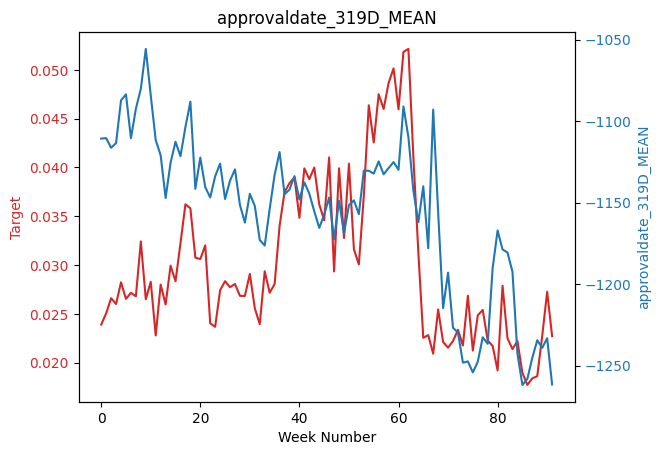

In [66]:
import matplotlib.pyplot as plt

# Sample DataFrame creation and groupby operation
# Assuming 'df' is already defined and includes 'week_num', 'target', 'numberofoverdueinstlmax_1039L_MAX', and 'partition'
t = 'approvaldate_319D_MEAN'
# Filtering the DataFrame and calculating the mean by 'week_num'
weekly_data = df.loc[df['partition'] == 'train', ['week_num', 'target', t]].groupby('week_num').mean()

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Create the first y-axis for the first variable
color = 'tab:red'
ax1.set_xlabel('Week Number')
ax1.set_ylabel('Target', color=color)
ax1.plot(weekly_data.index, weekly_data['target'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the second variable
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel(t, color=color)  # we already handled the x-label with ax1
ax2.plot(weekly_data.index, weekly_data[t], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show plot
plt.title(t)
plt.show()

In [ ]:
# placeholder for exploration code 

# training

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedGroupKFold, TimeSeriesSplit
import lightgbm as lgb 
from hyperopt import fmin, tpe, hp, SparkTrials, STATUS_OK
from hyperopt.pyll import scope
from functools import partial

In [ ]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

In [ ]:
def get_base_params():
    base_params = {
        'boosting_type':'gbdt',
        'random_state': 117,
        'objective': 'binary',
        'metric': 'auc',
        'extra_trees':True,
        'verbose': -1,
        'max_bin': 200,
#         'device_type': 'gpu',
#         'gpu_use_dp': True,
        
    }
    return base_params

In [ ]:
# set up search space
search_space_setup = {
    'feature_fraction': hp.uniform('feature_fraction', 0.3, .9),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.3, .9),
    'lambda_l1': hp.loguniform('lambda_l1', np.log(.000001), np.log(1000)),
    'lambda_l2': hp.loguniform('lambda_l2', np.log(.000001), np.log(1000)),
    'bagging_freq': scope.int(hp.uniform('bagging_freq', 2, 10)),
    'min_data_in_leaf': scope.int(hp.uniform('min_data_in_leaf', 100, 10000)),
    'learning_rate' : hp.uniform('learning_rate', 0.001, .1),
    'num_leaves': scope.int(hp.uniform('num_leaves', 20, 5000)),
    'min_gain_to_split': hp.uniform('min_gain_to_split', 0, 15),
}
search_space = get_base_params()
for k,v in search_space_setup.items():
    search_space[k] = v

In [ ]:
df.loc[df['partition']=='train','week_num'].sort_values().unique()

In [ ]:
def trial_fn(params,splits = None, n_months = 15):
    
    scores = []
    week_num = df.loc[df['partition']=='train','week_num'].sort_values().unique()
    for train_idx, valid_idx in splits:
        model = lgb.LGBMClassifier(**params)  
        model.fit(df.loc[train_idx,features], df.loc[train_idx,'target'],
                  eval_set=[(df.loc[valid_idx,features], df.loc[valid_idx,'target'])],
                  eval_metric='auc',
                  callbacks=[lgb.early_stopping(50)])

        score = roc_auc_score(df.loc[valid_idx,'target'],model.predict_proba(df.loc[valid_idx,features]))
        scores.append(score)
    
    score = np.mean(scores) - np.std(scores)
    out = {"status": STATUS_OK, "loss": -score} # always minimizes
    return out

In [ ]:
best_params = fmin(fn=partial(trial_fn, splits = splits, dataset = lgbtrain),
                    space=search_space,
                    algo=tpe.suggest,
                    max_evals=100,
                    timeout=60*60*6 # seconds
                  )
int_params = ['max_depth','n_estimators','bagging_freq','num_leaves']
bestp = get_base_params()
for k,v in best_params.items():
    if k in int_params:
        bestp[k] = int(v)
    else:
        bestp[k] = v
bestp

In [ ]:
for train_idx, valid_idx in splits:
    model = lgb.LGBMClassifier(**params)  
    model.fit(df.loc[train_idx,features], df.loc[train_idx,'target'],
              eval_set=[(df.loc[valid_idx,features], df.loc[valid_idx,'target'])],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(50)])
    model

# submission

In [ ]:
df.loc[df['partition']=='test',['case_id','score']].to_csv('submission.csv', index=False)